# Fast & Smart: Training and Tuning LightGBM

 ### 📄 Table of Contents

1. [LightGBM in a Nutshell](#lightgbm-in-a-nutshell)  
2. [Model Implementation and Optimization](#model-implementation-and-optimization)  
   - [Load Dataset](#load-dataset)  
   - [Training a Baseline LightGBM Classifier](#training-a-baseline-lightgbm-classifier)
   - [Evaluating the Baseline Model](#evaluating-the-baseline-model)  
   - [Optimizing LightGBM with Optuna](#optimizing-lightgbm-with-optuna)
   - [Training the Final Model with Optuna Parameters](#training-the-final-model-with-optuna-parameters)
3. [Benchmarking LightGBM vs XGBoost](#benchmarking-lightgbm-vs-xgboost)  
   - [Training Time Comparison](#training-time-comparison)  
   - [Accuracy Comparison](#accuracy-comparison)

--- 
<a id="lightgbm-in-a-nutshell"></a> 
 
## 🌰 LightGBM in a nutshell

**LightGBM** (Light Gradient Boosting Machine) is a high-performance implementation of Gradient Boosting Decision Trees (GBDT), developed by **[Microsoft](https://lightgbm.readthedocs.io/en/stable/)**.

It is specifically designed for **speed, memory efficiency, and scalability** when working with **large-scale tabular datasets**.

Compared to other boosting libraries like XGBoost, LightGBM is typically **faster**, uses **less memory**, and can provide **equal or better predictive performance**.

#### **Core Characteristics**

- **Gradient Boosting Framework** 
  LightGBM is based on the boosting principle, where multiple weak learners (typically shallow decision trees) are trained sequentially to correct the errors of the previous ones. The final prediction is a weighted sum of all individual models.

- **Leaf-wise Tree Growth**  
  Unlike level-wise algorithms (e.g., XGBoost), LightGBM grows trees **leaf-wise**, meaning at each step, it splits the leaf with the **highest loss reduction (gain)**, rather than growing all leaves at the same depth. This usually leads to **deeper and more accurate trees**, but may risk overfitting if not regularized.

- **Histogram-based Splitting**  
  LightGBM builds histograms to bucket continuous feature values. This reduces the number of possible split points, leading to:
  - Faster training  
  - Lower memory usage  
  - Better handling of high-cardinality data

- **Native Categorical Feature Support**  
  LightGBM can directly handle **categorical variables** without one-hot encoding. It learns the **best way to split** those categories based on their contribution to prediction.
- **GPU Support**  
  Training can be accelerated significantly on large datasets using GPUs.

#### **When Should You Use LightGBM?**

Use LightGBM when:

- Your data is **tabular** (structured, rows × columns)
- You need **high predictive accuracy**
- You care about **training speed and memory efficiency**
- You want to **handle categorical variables** without complex preprocessing


----
<a id="model-implementation-and-optimization"></a> 

## 💡 Model Implementation and Optimization

To demonstrate how LightGBM works in practice, we’ll use a well-known benchmark dataset: the Breast Cancer Wisconsin dataset. It is included in `scikit-learn` and contains features computed from digitized images of breast mass biopsies.

This dataset is commonly used for binary classification tasks. The target variable indicates whether a tumor is malignant or benign.

We’ll walk through:
- Loading and inspecting the dataset
- Building a baseline LightGBM model
- Tuning it with Optuna
- Evaluating performance on a held-out test set
- Training time and predictive performance against XGBoost

While this is a small dataset, it allows us to focus on methodology rather than computational constraints.

#### Setup
Import required dependencies

In [ ]:
# !pip install lightgbm optuna scikit-learn matplotlib seaborn --quiet

#### Load Dataset

The Breat Cancer Prediciton dataset comes from the University of Wisconsin Hospitals and is commonly used for binary classification tasks.

It contains features extracted from images of breast tissue, with the goal of classifying tumors as **benign** or **malignant**.

🔗 [Dataset on Kaggle](https://www.kaggle.com/datasets/merishnasuwal/breast-cancer-prediction-dataset)

In [4]:
import os
import pandas as pd
from sklearn.datasets import load_breast_cancer

# Load dataset
PATH = os.getcwd()
data = pd.read_csv(os.path.join(PATH, "Breast_cancer_data.xls"))

X = data.drop("diagnosis", axis=1)
y = data["diagnosis"]

X.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness
0,17.99,10.38,122.80,1001.0,0.11840
1,20.57,17.77,132.90,1326.0,0.08474
2,19.69,21.25,130.00,1203.0,0.10960
3,11.42,20.38,77.58,386.1,0.14250
4,20.29,14.34,135.10,1297.0,0.10030


⚠️ *Disclaimer: Data wrangling and EDA are like vegetables — important, but not part of this meal. They're out of scope for now.*

#### Training a Baseline LightGBM Classifier

**Train/test split and basic LightGBM training**

Before tuning the model, we establish a performance baseline using default hyperparameters. This allows us to later measure the impact of optimization.

We'll start by splitting the data into training and test sets, then train a basic LightGBM classifier.


In [27]:
import time
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

import lightgbm as lgb

# Create a basic LightGBM model
start_time = time.time()

model = lgb.LGBMClassifier(random_state=42, verbose=-1)
model.fit(X_train, y_train)

lgb_time = time.time() - start_time

#### Evaluating the Baseline Model

**Assessing classification performance with a confusion matrix and detailed metrics**

Accuracy alone doesn't tell the full story, especially in imbalanced or high-stakes classification tasks. We’ll use the confusion matrix and classification report to gain a more complete picture of the model's behavior.

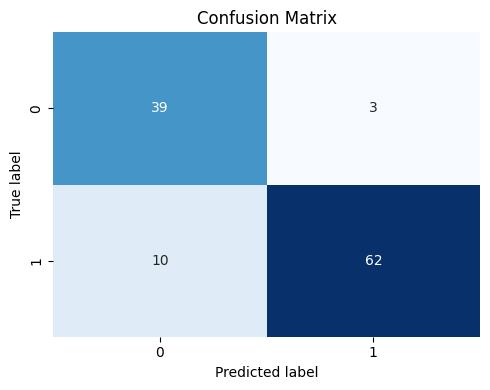

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.93      0.86        42
           1       0.95      0.86      0.91        72

    accuracy                           0.89       114
   macro avg       0.87      0.89      0.88       114
weighted avg       0.90      0.89      0.89       114



In [7]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Predict on the test set
y_pred = model.predict(X_test)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


#### Optimizing LightGBM with Optuna

**Why tune hyperparameters?**

The performance of gradient boosting models is highly sensitive to their hyperparameters. Manually tuning them is time-consuming and inefficient.

**Why use Optuna?**

[Optuna](https://optuna.org/) is a state-of-the-art optimization framework that uses techniques like **Bayesian optimization**, **early stopping (pruning)**, and **parallel search** to efficiently find good hyperparameter configurations.

We’ll define an objective function that trains a LightGBM model with a given set of hyperparameters, evaluates it using cross-validation, and returns a metric to be maximized.


In [8]:
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

def objective(trial):
    param_grid = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 20, 150),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 50),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-3, 10.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-3, 10.0, log=True),
    }

    model = lgb.LGBMClassifier(
        n_estimators=100,
        random_state=42,
        verbose=-1,
        **param_grid
    )

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=cv, scoring="accuracy")
    return scores.mean()

# Run the optimization
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=30, timeout=300)

# Get the best parameters
best_params = study.best_params
print("Best parameters:", best_params)

c:\Users\acarballo\anaconda3\envs\mlenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-15 19:30:01,654] A new study created in memory with name: no-name-7e1b0cd9-cf48-4bba-af4c-eef46d180301
[I 2025-07-15 19:30:01,775] Trial 0 finished with value: 0.8351648351648352 and parameters: {'learning_rate': 0.0028091346771931306, 'num_leaves': 128, 'max_depth': 7, 'min_child_samples': 48, 'subsample': 0.5929090079190025, 'colsample_bytree': 0.9079533065483945, 'reg_alpha': 0.2906470615163148, 'reg_lambda': 0.0011326300108212273}. Best is trial 0 with value: 0.8351648351648352.
[I 2025-07-15 19:30:01,913] Trial 1 finished with value: 0.6263736263736264 and parameters: {'learning_rate': 0.0018526777925212611, 'num_leaves': 134, 'max_depth': 10, 'min_child_samples': 26, 'subsample': 0.996081617171345, 'colsample_b

Best parameters: {'learning_rate': 0.11117611128306479, 'num_leaves': 43, 'max_depth': 12, 'min_child_samples': 49, 'subsample': 0.6440095131020271, 'colsample_bytree': 0.9817449017017511, 'reg_alpha': 0.01001214167893605, 'reg_lambda': 9.032205405184754}


#### Training the Final Model with Optuna Parameters

**Retraining with the optimal configuration**

Now that we have a set of tuned hyperparameters, we retrain the model on the full training set and evaluate its performance on the test set.


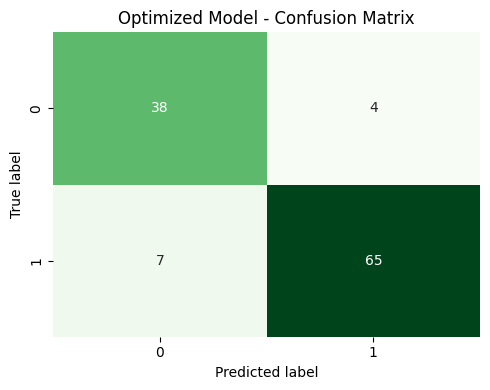

Optimized Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.90      0.87        42
           1       0.94      0.90      0.92        72

    accuracy                           0.90       114
   macro avg       0.89      0.90      0.90       114
weighted avg       0.91      0.90      0.90       114



In [10]:
# Retrieve best parameters
best_params = study.best_params

# Add fixed parameters
best_params.update({
    "n_estimators": 100,
    "random_state": 42,
    "verbose": -1
})

# Train final model
final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train, y_train)

# Predict and evaluate
y_pred_optimized = final_model.predict(X_test)

# Confusion matrix and classification report
cm_opt = confusion_matrix(y_test, y_pred_optimized)

plt.figure(figsize=(5, 4))
sns.heatmap(cm_opt, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Optimized Model - Confusion Matrix")
plt.tight_layout()
plt.show()

print("Optimized Classification Report:\n")
print(classification_report(y_test, y_pred_optimized))


---
<a id="benchmarking-lightgbm-vs-xgboost"></a> 

## 📊 Benchmarking LightGBM vs XGBoost

**LightGBM and XGBoost are two of the most widely used gradient boosting libraries.**

Both are optimized implementations of the gradient boosting algorithm and are designed for high-performance modeling on tabular datasets. They are frequently used in data science competitions, real-world machine learning systems, and AutoML frameworks.

Although they aim to solve the same type of problems, their internal mechanisms differ:

- **LightGBM** uses a **leaf-wise** tree growth strategy and histogram-based feature binning for faster training.
- **XGBoost** uses a **level-wise** growth strategy and handles sparse data well, but can be slower.

In this notebook, we compare them in two ways:
- **Training time**, to assess efficiency.
- **Accuracy**, to evaluate predictive performance.

This helps us understand not only which model is faster, but whether that speed comes at the cost of accuracy — or if LightGBM can outperform in both aspects.


#### Training Time Comparison

**How fast is LightGBM compared to XGBoost?**

Both LightGBM and XGBoost are optimized implementations of gradient boosting. However, LightGBM is specifically engineered for speed and memory efficiency.

To highlight this, we measured the time each model took to train on the same dataset, with default hyperparameters and identical train/test splits.

The chart below shows the training time in seconds. As expected, LightGBM completes training significantly faster while maintaining similar predictive performance.

This makes LightGBM a strong choice when working with large datasets or under time/resource constraints.


In [ ]:
import time
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Train XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)

start_time = time.time()
xgb_model.fit(X_train, y_train)
xgb_time = time.time() - start_time


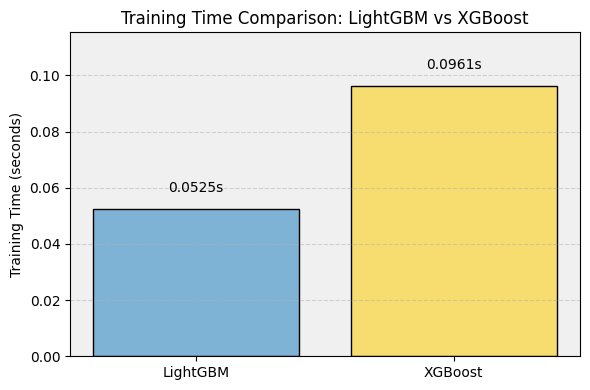

In [31]:
import matplotlib.pyplot as plt

labels = ["LightGBM", "XGBoost"]
times = [lgb_time, xgb_time]
colors = ["#7FB3D5", "#F7DC6F"]

plt.figure(figsize=(6, 4))
plt.style.use("default")
plt.gca().set_facecolor("#f0f0f0")

bars = plt.bar(labels, times, color=colors, edgecolor="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.005,
             f"{height:.4f}s", ha='center', va='bottom', fontsize=10)

plt.ylabel("Training Time (seconds)")
plt.title("Training Time Comparison: LightGBM vs XGBoost")
plt.ylim(0, max(times) * 1.2)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()


#### Accuracy Comparison

**How do the models perform in terms of prediction accuracy?**

While LightGBM is typically faster, it's important to also compare predictive performance. Here we train a basic XGBoost model with default settings and compare its accuracy against the baseline LightGBM model.

This helps assess whether there's a trade-off between speed and quality, or if one model dominates on both fronts.


In [32]:
# Predict and evaluate
y_pred_xgb = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, y_pred_xgb)

# Compare with LightGBM baseline
lgb_acc = accuracy_score(y_test, model.predict(X_test))

XGBoost Accuracy:   0.8947
LightGBM Accuracy:  0.8860


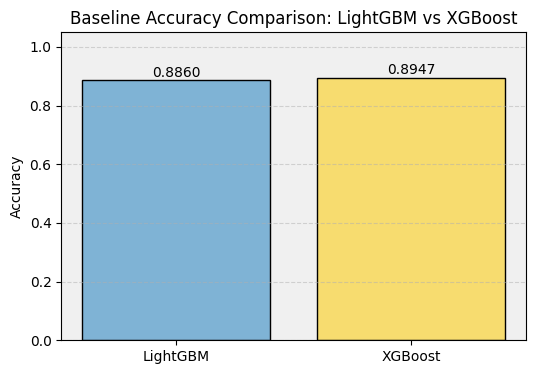

In [36]:
accuracies = [lgb_acc, xgb_acc]
labels = ["LightGBM", "XGBoost"]
colors = ["#7FB3D5", "#F7DC6F"]

# Crear gráfico
plt.figure(figsize=(6, 4))
plt.gca().set_facecolor("#f0f0f0") 

bars = plt.bar(labels, accuracies, color=colors, edgecolor="black")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.002,
             f"{height:.4f}", ha="center", va="bottom", fontsize=10)

plt.ylabel("Accuracy")
plt.ylim(0, 1.05)
plt.title("Baseline Accuracy Comparison: LightGBM vs XGBoost")
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()
